In [63]:

'''Trains a Siamese MLP on pairs of digits from the MNIST dataset.
It follows Hadsell-et-al.'06 [1] by computing the Euclidean distance on the
output of the shared network and by optimizing the contrastive loss (see paper
for more details).

# References
- Dimensionality Reduction by Learning an Invariant Mapping
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
Gets to 97.2% test accuracy after 20 epochs.
2 seconds per epoch on a Titan X Maxwell GPU
'''
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random

import matplotlib.pyplot as plt
import cv2

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K

num_classes = 10

print("Keras",keras.__version__)
print("tf",K.tf.__version__)

Keras 1.2.2
tf 1.0.0


In [64]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1.0
    square_pred = K.square(y_pred)
    #square_pred = K.maximum(y_pred-margin, 0) #y_pred #K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


In [55]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


In [56]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    #for 2D view
    x = Dense(  2)(x)
    return Model(input, x)


In [57]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))



In [58]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

print(input_shape)

(28, 28)


In [59]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

print("tr_pairs=",tr_pairs.shape,"tr_y=",tr_y.shape)
print("te_pairs=",te_pairs.shape,"te_y=",te_y.shape)

tr_pairs= (108400, 2, 28, 28) tr_y= (108400,)
te_pairs= (17820, 2, 28, 28) te_y= (17820,)


In [60]:
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)


In [61]:
# train
epochs = 20
batch_size=1000
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=batch_size,
          nb_epoch=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))


Train on 108400 samples, validate on 17820 samples
Epoch 1/20


InvalidArgumentError: Reshape cannot infer the missing input size for an empty tensor unless all specified input sizes are non-zero
	 [[Node: Reshape_25 = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_input_26_0/_509, stack_25)]]
	 [[Node: Mean_44/_537 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_785_Mean_44", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Reshape_25', defined at:
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-60-979c35addc07>", line 10, in <module>
    processed_a = base_network(input_a)
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/keras/engine/topology.py", line 572, in __call__
    self.add_inbound_node(inbound_layers, node_indices, tensor_indices)
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/keras/engine/topology.py", line 635, in add_inbound_node
    Node.create_node(self, inbound_layers, node_indices, tensor_indices)
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/keras/engine/topology.py", line 166, in create_node
    output_tensors = to_list(outbound_layer.call(input_tensors[0], mask=input_masks[0]))
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/keras/engine/topology.py", line 2247, in call
    output_tensors, output_masks, output_shapes = self.run_internal_graph(inputs, masks)
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/keras/engine/topology.py", line 2390, in run_internal_graph
    computed_mask))
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/keras/layers/core.py", line 483, in call
    return K.batch_flatten(x)
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 1629, in batch_flatten
    x = tf.reshape(x, stack([-1, prod(shape(x)[1:])]))
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2630, in reshape
    name=name)
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/francisco/anaconda3/envs/dl/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Reshape cannot infer the missing input size for an empty tensor unless all specified input sizes are non-zero
	 [[Node: Reshape_25 = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/gpu:0"](_recv_input_26_0/_509, stack_25)]]
	 [[Node: Mean_44/_537 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_785_Mean_44", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [34]:
# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 61.29%
* Accuracy on test set: 60.83%


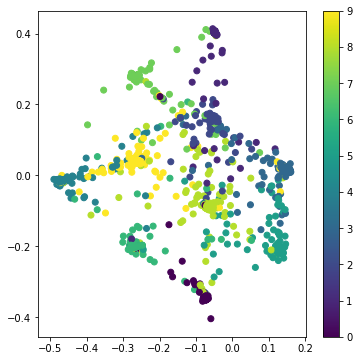

In [35]:
#TOFINISH
batch_size=128
encoder=base_network#check this
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()